In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epirecipes/recipe.py
/kaggle/input/epirecipes/utils.py
/kaggle/input/epirecipes/full_format_recipes.json
/kaggle/input/epirecipes/epi_r.csv


In [14]:
!pip install pyspark


In [15]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t
import os 
from os.path import isfile, join
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pprint import pprint
spark = SparkSession.builder.getOrCreate()

In [16]:
df1 = spark.read.csv("../input/epirecipes/epi_r.csv", header = True,inferSchema=True)


In [17]:
#số lượng label
print('so luong columns:')
print(len(df1.columns))
print('so luong gia tri:')
print(df1.count())
#

so luong columns:
680
so luong gia tri:
20057


In [18]:
#chọn các giá trị trên predict cho calories
data= df1.select(["title","rating","calories","protein","fat",'sodium'])

In [19]:
data.show()

+--------------------+------+--------+-------+----+------+
|               title|rating|calories|protein| fat|sodium|
+--------------------+------+--------+-------+----+------+
|Lentil, Apple, an...|   2.5|   426.0|   30.0| 7.0| 559.0|
|Boudin Blanc Terr...| 4.375|   403.0|   18.0|23.0|1439.0|
|Potato and Fennel...|  3.75|   165.0|    6.0| 7.0| 165.0|
|Mahi-Mahi in Toma...|   5.0|    null|   null|null|  null|
|Spinach Noodle Ca...| 3.125|   547.0|   20.0|32.0| 452.0|
|      The Best Blts | 4.375|   948.0|   19.0|79.0|1042.0|
|Ham and Spring Ve...| 4.375|    null|   null|null|  null|
|Spicy-Sweet Kumqu...|  3.75|    null|   null|null|  null|
|Korean Marinated ...| 4.375|   170.0|    7.0|10.0|1272.0|
|Ham Persillade wi...|  3.75|   602.0|   23.0|41.0|1696.0|
|Yams Braised with...|  3.75|   256.0|    4.0| 5.0|  30.0|
|  Spicy Noodle Soup | 4.375|    null|   null|null|  null|
|Banana-Chocolate ...| 4.375|   766.0|   12.0|48.0| 439.0|
|Beef Tenderloin w...| 4.375|   174.0|   11.0|12.0| 176.

In [20]:
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----+------+--------+-------+----+------+
|title|rating|calories|protein| fat|sodium|
+-----+------+--------+-------+----+------+
|    0|     5|    4121|   4166|4188|  4124|
+-----+------+--------+-------+----+------+



In [21]:
data=df1.withColumn('rating',f.col('rating').cast('float'))\
.withColumn('calories',f.col('calories').cast('float'))\
.withColumn('protein',f.col('protein').cast('float'))\
.withColumn('fat',f.col('fat').cast('float'))\
.withColumn('sodium',f.col('sodium').cast('float'))

In [22]:
value1=data.approxQuantile("rating", [0.5], 0)[0]
value2=data.approxQuantile("calories", [0.5], 0)[0]
value3=data.approxQuantile("protein", [0.5], 0)[0]
value4=data.approxQuantile("fat", [0.5], 0)[0]
                        

In [23]:
#count data
data1=data.na.fill(value=value1,subset=["rating"])\
.na.fill(value=value2,subset=["calories"])\
.na.fill(value=value3,subset=["protein"])\
.na.fill(value=value4,subset=["fat"])
print(data1.count())

20057


In [24]:
data2=data1.distinct()
print(data2.count())


18256


In [25]:
#loai bo trung
dropDisDF=data1.dropDuplicates(['rating','calories','protein','fat','sodium','title'])
print(dropDisDF.count())

18240


In [26]:
data3=data2.withColumn('title',f.col('title').cast('String'))\
.withColumn('rating',f.col('rating').cast('float'))\
.withColumn('calories',f.col('calories').cast('float'))\
.withColumn('protein',f.col('protein').cast('float'))\
.withColumn('fat',f.col('fat').cast('float'))\
.withColumn('sodium',f.col('sodium').cast('float'))
data3.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: float (nullable = false)
 |-- calories: float (nullable = false)
 |-- protein: float (nullable = false)
 |-- fat: float (nullable = false)
 |-- sodium: float (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)
 

In [27]:
data3.describe(['rating','calories','protein','fat','sodium']).show()

+-------+------------------+-----------------+-----------------+------------------+-----------------+
|summary|            rating|         calories|          protein|               fat|           sodium|
+-------+------------------+-----------------+-----------------+------------------+-----------------+
|  count|             18256|            18256|            18256|             18256|            14501|
|   mean| 3.714361031989483|5328.395808227432|74.79881271910605|291.20880806310254|6573.591269567616|
| stddev|1.3337914959492605| 334040.621588061|3126.647367999641|19001.787736987673|348417.2350038467|
|    min|               0.0|              0.0|              0.0|               0.0|              0.0|
|    max|               5.0|      3.0111218E7|         236489.0|         1722763.0|       2.767511E7|
+-------+------------------+-----------------+-----------------+------------------+-----------------+



In [28]:
#check outlier vị trị 95%
print(data3.approxQuantile("calories", [0.95], 0))
print(data3.approxQuantile("protein", [0.95], 0))
print(data3.approxQuantile("fat", [0.95], 0))
print(data3.approxQuantile("sodium", [0.95], 0))


[1186.0]
[68.0]
[76.0]
[2058.0]


In [29]:
#loại bỏ các trường hợp outlier
data4=data3.filter(data3.calories > 0)\
.filter(data3.protein>0)\
.filter(data3.fat>0)\
.filter(data3.sodium>0)\
.filter(data3.calories<1186)\
.filter(data3.protein<68)\
.filter(data3.fat<76)\
.filter(data.sodium<2058)
data4.count()

11465

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

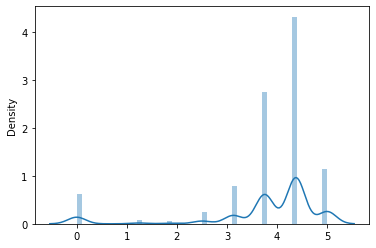

In [30]:
#check columns rating
import seaborn as sns
df=data4.select('rating')
sns.distplot(df.toPandas())
#check columns rating


In [41]:
a=['almond',
 'anchovy',
 'anise',
 'appetizer',
 'apple',
 'apricot',
 'asian pear',
 'asparagus',
 'aspen',
 'avocado',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bean',
 'beef',
 'beef rib',
 'beef tenderloin',
 'beet',
 'bell pepper',
 'berry',
 'blue cheese',
 'blueberry',
 'boil',
 'bread',
 'breakfast',
 'brie',
 'brine',
 'brisket',
 'broccoli',
 'broil',
 'brown rice',
 'brownie',
 'brussel sprout',
 'buffalo',
 'burrito',
 'butter',
 'buttermilk',
 'butternut squash',
 'cabbage',
 'cake',
 'calories',
 'candy',
 'cantaloupe',
 'capers',
 'caraway',
 'cardamom',
 'carrot',
 'cashew',
 'cauliflower',
 'caviar',
 'celery',
 'chard',
 'cheese',
 'cherry',
 'chestnut',
 'chicken',
 'chili',
 'chive',
 'chocolate',
 'cilantro',
 'cinnamon',
 'citrus',
 'clove',
 'coconut',
 'cod',
 'cookie',
 'coriander',
 'corn',
 'cornmeal',
 'cottage cheese',
 'crab',
 'cranberry',
 'cranberry sauce',
 'cream cheese',
 'cucumber',
 'cumin',
 'cupcake',
 'currant',
 'curry',
 'custard',
 'dessert',
 'dill',
 'dinner',
 'dip',
 'dried fruit',
 'duck',
 'egg',
 'eggplant',
 'escarole',
 'fat',
 'fennel',
 'fig',
 'fish',
 'flat bread',
 'fritter',
 'fruit',
 'garlic',
 'ginger',
 'goat cheese',
 'goose',
 'granola',
 'grape',
 'grapefruit',
 'green onion/scallion',
 'grill',
 'ground beef',
 'guava',
 'halibut',
 'ham',
 'hamburger',
 'healthy',
 'herb',
 'high fiber',
 'honey',
 'horseradish',
 'hot pepper',
 'ice cream',
 'iced tea',
 'jam or jelly',
 'kale',
 'kiwi',
 'kosher',
 'kumquat',
 'lamb',
 'lamb chop',
 'lamb shank',
 'lasagna',
 'leafy green',
 'leek',
 'legume',
 'lemon',
 'lemongrass',
 'lentil',
 'lettuce',
 'lobster',
 'low cal',
 'lunch',
 'lychee',
 'macaroni and cheese',
 'mango',
 'marinade',
 'marinate',
 'meat',
 'meatball',
 'meatloaf',
 'melon',
 'mint',
 'molasses',
 'mozzarella',
 'muffin',
 'mushroom',
 'mussel',
 'mustard',
 'mustard greens',
 'noodle',
 'nutmeg',
 'oat',
 'oatmeal',
 'octopus',
 'okra',
 'olive',
 'omelet',
 'onion',
 'orange',
 'oregano',
 'pancake',
 'papaya',
 'paprika',
 'parsley',
 'passion fruit',
 'pasta',
 'pastry',
 'pea',
 'peach',
 'peanut',
 'peanut butter',
 'pear',
 'pecan',
 'pepper',
 'persimmon',
 'pickles',
 'pie',
 'pine nut',
 'pineapple',
 'pistachio',
 'plantain',
 'plum',
 'pomegranate',
 'pork',
 'pork chop',
 'pork rib',
 'pork tenderloin',
 'pot pie',
 'potato',
 'potato salad',
 'poultry',
 'poultry sausage',
 'protein',
 'pumpkin',
 'quail',
 'rabbit',
 'radish',
 'raisin',
 'raspberry',
 'red wine',
 'rice',
 'roast',
 'rosemary',
 'rye',
 'saffron',
 'sage',
 'salad',
 'salmon',
 'sandwich',
 'sardine',
 'sauce',
 'sausage',
 'sauté',
 'scallop',
 'seafood',
 'self',
 'sesame',
 'sesame oil',
 'shallot',
 'shrimp',
 'simmer',
 'skewer',
 'snapper',
 'sodium',
 'sorbet',
 'sour cream',
 'sourdough',
 'soy',
 'soy sauce',
 'spinach',
 'squash',
 'squid',
 'steak',
 'stew',
 'strawberry',
 'sugar snap pea',
 'swiss cheese',
 'swordfish',
 'tamarind',
 'tangerine',
 'tapioca',
 'tarragon',
 'tested & improved',
 'thyme',
 'tilapia',
 'tofu',
 'tomato',
 'tuna',
 'turkey',
 'turnip',
 'veal',
 'vegan',
 'vegetable',
 'vegetarian',
 'venison',
 'vinegar',
 'walnut',
 'watercress',
 'watermelon',
 'white wine',
 'whole wheat',
 'wild rice',
 'yellow squash',
 'yogurt',
 'zucchini',
  'rating']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

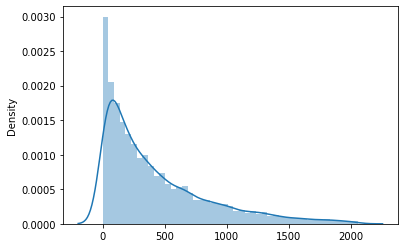

In [32]:
#check columns rating
df=data4.select('sodium')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

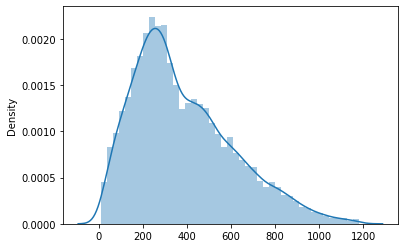

In [33]:
#check columns rating
df=data4.select('calories')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

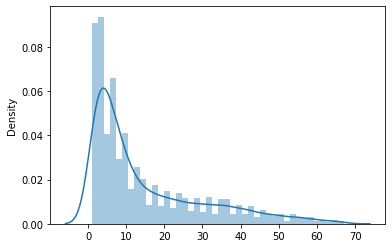

In [34]:
#check columns rating
df=data4.select('protein')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

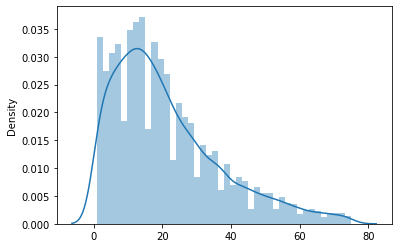

In [35]:
#check columns rating
df=data4.select('fat')
sns.distplot(df.toPandas())

In [42]:
#chọn thuộc tinh có column mean!=0;
data5= data4.select(a)

In [43]:
# correctlation của các thuộc tính calories,fat,sodium,proten,..
def corr(a,b):
    print('coreclation cua',a,'va',b,'la:',data5.corr(a,b))
corr('calories','fat')
corr('calories','protein')
corr('calories','sodium')
corr('fat','sodium')
corr('fat','protein')
corr('protein','sodium')
corr('rating','sodium')
corr('rating','calories')
corr('rating','fat')
corr('rating','protein')

coreclation cua calories va fat la: 0.837299285125589
coreclation cua calories va protein la: 0.6375134190911126
coreclation cua calories va sodium la: 0.4206939796890131
coreclation cua fat va sodium la: 0.3427457634732143
coreclation cua fat va protein la: 0.5274882673349054
coreclation cua protein va sodium la: 0.5297271893792865
coreclation cua rating va sodium la: 0.0786433397061752
coreclation cua rating va calories la: 0.10872941859073906
coreclation cua rating va fat la: 0.11068943146805965
coreclation cua rating va protein la: 0.09555357709507022


In [44]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#Vecto "calories","fat","sodium","protein" to vector
#Predict rating
assembler=VectorAssembler(inputCols=["calories","fat","sodium","protein"],outputCol='features')
output=assembler.transform(data5)
output.select('features','rating').show(5)
#Vecto "calories","fat","sodium","protein" to vector
#Predict Calories
assembler1=VectorAssembler(inputCols=["fat","sodium","protein",'low cal'],outputCol='features')
output1=assembler1.transform(data5)
output1.select('features','calories').show(5)

+--------------------+------+
|            features|rating|
+--------------------+------+
|[426.0,7.0,559.0,...|   2.5|
|[279.0,30.0,206.0...|  3.75|
|[113.0,9.0,314.0,...| 4.375|
|[611.0,34.0,391.0...| 4.375|
|[78.0,7.0,180.0,3.0]| 4.375|
+--------------------+------+
only showing top 5 rows

+--------------------+--------+
|            features|calories|
+--------------------+--------+
|[7.0,559.0,30.0,0.0]|   426.0|
|[30.0,206.0,3.0,0.0]|   279.0|
| [9.0,314.0,7.0,0.0]|   113.0|
|[34.0,391.0,15.0,...|   611.0|
| [7.0,180.0,3.0,0.0]|    78.0|
+--------------------+--------+
only showing top 5 rows



In [45]:
#train calories
data7= output1.select('features','calories')
#chia dữ liệu train test
train, test = data7.randomSplit([0.7, 0.3], seed=42)
from pyspark.ml.regression import LinearRegression
#traijn LinearRegression
ship_lr=LinearRegression(featuresCol='features',labelCol='calories')
trained_ship_model=ship_lr.fit(train)
#đánh giá Rsquared
ship_results=trained_ship_model.evaluate(train)
print('Rsquared Error Train:',ship_results.r2)
print('RMSE Train',ship_results.rootMeanSquaredError)
ship_results=trained_ship_model.evaluate(test)
print('Rsquared Error Test:',ship_results.r2)
print('RMSE Test',ship_results.rootMeanSquaredError)

Rsquared Error Train: 0.7514975275517402
RMSE Train 114.14668015797893
Rsquared Error Test: 0.771123004546649
RMSE Test 108.15641478231579


In [46]:
b=a.copy()
b.remove('kosher')
train_data, test_data = data5.randomSplit([0.8,0.2])
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#Predict Calories
assembler1=VectorAssembler(inputCols=b,outputCol='features')
output2=assembler1.transform(data5)
train_data1, test_data1 = output2.randomSplit([0.8,0.2])
output1.select('features','kosher').show(5)

data8=train_data1.select('features','kosher')
from pyspark.ml.classification import LogisticRegression
lrgen1 = LogisticRegression(labelCol="kosher", featuresCol="features", maxIter=100, regParam=0.001, elasticNetParam=1, standardization=True)
linearModelgen1 = lrgen1.fit(data8)
data8


+--------------------+------+
|            features|kosher|
+--------------------+------+
|[7.0,559.0,30.0,0.0]|   0.0|
|[30.0,206.0,3.0,0.0]|   0.0|
| [9.0,314.0,7.0,0.0]|   0.0|
|[34.0,391.0,15.0,...|   1.0|
| [7.0,180.0,3.0,0.0]|   0.0|
+--------------------+------+
only showing top 5 rows



DataFrame[features: vector, kosher: double]

In [47]:
trainingSummary = linearModelgen1.summary
accuracy = trainingSummary.accuracy
print(accuracy)

0.9032188143491926


In [48]:
predictions = linearModelgen1.transform(test_data1)
predictions.select('features','kosher').show(5)


+--------------------+------+
|            features|kosher|
+--------------------+------+
|(272,[42,91,151,1...|   0.0|
|(272,[42,62,91,99...|   0.0|
|(272,[42,91,131,1...|   0.0|
|(272,[20,42,91,98...|   0.0|
|(272,[11,42,91,11...|   1.0|
+--------------------+------+
only showing top 5 rows

